In [1]:
import keras, os
import numpy as np
import yfinance as yf
from models import model1, model2
from matplotlib import pyplot as plt 

2025-01-24 07:52:33.397990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737726753.426739 2523672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737726753.431047 2523672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 07:52:33.455722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download Stock Data

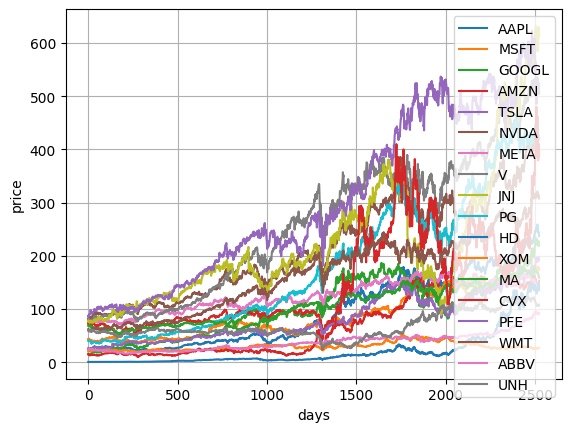

In [2]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'V', 'JNJ', 'PG', 'HD', 'XOM', 'MA', 'CVX', 'PFE', 'WMT', 'ABBV', 'UNH'
    ]

download = False
if download:
    stock_data = yf.download(tickers, start='2015-01-01', end='2025-01-11')
    closing_prices = stock_data['Close']
    P = closing_prices.to_numpy()
    np.save('stock_prices.npy', P)
else:
    P = np.load('stock_prices.npy')

plt.figure()
for price, ticker in zip(P.T, tickers):
    plt.plot(price,label=ticker)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.grid()
plt.show()

### Hyperparameters

In [3]:
n_timesteps = 30
n_pred = 1
input_shape=((n_timesteps, P.shape[1]))
embed_dim = 512
n_heads = 8
n_layers = 10
ff_dim = embed_dim*4

batch_size = 32
epochs = 100
lr = 1e-4

### Data Pipeline

In [4]:
def preprocess_dataset(data, n_timesteps, n_pred):
    n_examples = data.shape[0]-n_timesteps-n_pred
    scales = []
    segments = []
    for idx in range(n_examples):
        scale = data[idx]
        segments.append(data[idx:idx+n_timesteps+n_pred]/scale)
        scales.append(scale)
    segments = np.array(segments)
    scales = np.array(scales)
    return segments[:,:-1], segments[:,-1], scales

X, Y, S = preprocess_dataset(P, n_timesteps, n_pred)

X_train, X_valid = X[:X.shape[0]*80//100], X[X.shape[0]*80//100:]
Y_train, Y_valid = Y[:Y.shape[0]*80//100], Y[Y.shape[0]*80//100:]
S_valid = S[S.shape[0]*80//100:]

print(f'{X_train.shape=}, {X_valid.shape=}')
print(f'{Y_train.shape=}, {Y_valid.shape=}')

X_train.shape=(1992, 30, 18), X_valid.shape=(499, 30, 18)
Y_train.shape=(1992, 18), Y_valid.shape=(499, 18)


Plot random examples

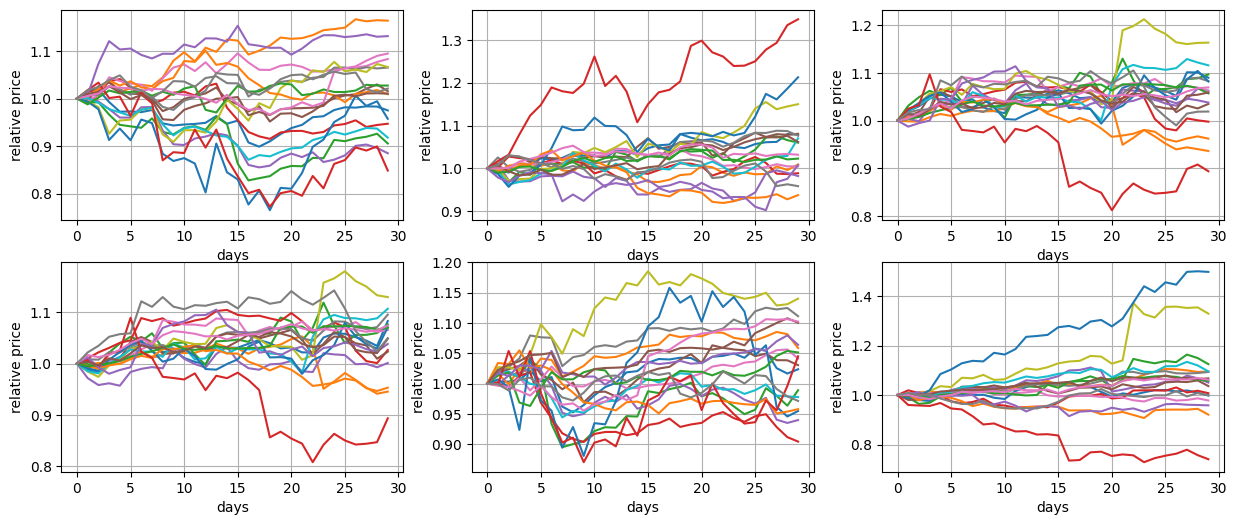

In [5]:
n_rows = 2
n_cols = 3

plt.figure(figsize=(n_cols*5, n_rows*3))
for k in range(n_rows*n_cols):
    idx = np.random.randint(0, X_valid.shape[0])
    plt.subplot(n_rows, n_cols, k+1)    
    plt.plot(X_valid[idx])
    plt.xlabel('days')
    plt.ylabel('relative price')
    plt.grid()
plt.show()

In [6]:
def compile(model, checkpoint, lr):
    model.summary()
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.MeanAbsoluteError(),
        )    
    if checkpoint is not None:
        if os.path.exists(checkpoint):
            print(f'Loaded model checkpoint "{checkpoint}"')
            model = model.load_weights(checkpoint)
        else:
            print(f'New model "{checkpoint}"')
            
def train(model, epochs, checkpoint):
    history = model.fit( 
        x=X_train,
        y=Y_train,
        epochs=epochs,
        validation_data=(X_valid, Y_valid),
        shuffle=True, 
        callbacks=
        [
            keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True),
        ])
    return history

### Train Model

In [7]:
m1 = model1(input_shape, n_layers, embed_dim, n_heads, ff_dim)
m1_checkpoint = './checkpoints/model1.weights.h5'
compile(m1, m1_checkpoint, lr)

I0000 00:00:1737726758.079201 2523672 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 512)        │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention      │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_1    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_2    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_3    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_4    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_5    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_6    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_7    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_8    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_self_attention_9    │ (None, 30, 512)        │    10,504,192 │
│ (TransformerSelfAttention)      │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 18)             │       276,498 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,328,146 (401.79 MB)

 Trainable params: 105,328,146 (401.79 MB)

 Non-trainable params: 0 (0.00 B)

New model "./checkpoints/model1.weights.h5"


In [8]:
history = train(m1, epochs, m1_checkpoint)

Epoch 1/100


I0000 00:00:1737726778.209374 2523810 service.cc:148] XLA service 0x7f5f50002e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737726778.209494 2523810 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-24 07:52:58.679208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737726780.853250 2523810 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-24 07:53:03.545969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 8 bytes spill stores, 8 bytes spill loads

2025-01-24 07:53:04.047406: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 352 bytes sp

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.9992

2025-01-24 07:53:26.090874: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 352 bytes spill stores, 216 bytes spill loads

2025-01-24 07:53:26.431511: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 756 bytes spill stores, 444 bytes spill loads

2025-01-24 07:53:27.077969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 204 bytes spill stores, 476 bytes spill loads

2025-01-24 07:53:27.555288: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 244 bytes spill stores, 244 bytes spill loads

2025-01-24 07:53:27.773529: I external/local_xla/xla/strea

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - loss: 0.9951

2025-01-24 07:53:39.515186: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 256 bytes spill stores, 256 bytes spill loads

2025-01-24 07:53:39.643175: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_82', 352 bytes spill stores, 216 bytes spill loads

2025-01-24 07:53:39.685000: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 756 bytes spill stores, 444 bytes spill loads

2025-01-24 07:53:39.797192: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 244 bytes spill stores, 244 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 464ms/step - loss: 0.9911 - val_loss: 0.3849
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.6362 - val_loss: 0.2313
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.5927 - val_loss: 0.2132
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.5964 - val_loss: 0.2583
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.5771 - val_loss: 0.2890
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.5721 - val_loss: 0.2752
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.5450 - val_loss: 0.2023
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - loss: 0.5189 - val_loss: 0.1594
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.4704 - val_loss: 0.1624
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.3949 - val_loss: 0.2090
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.3091 - val_loss: 0.1060
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156

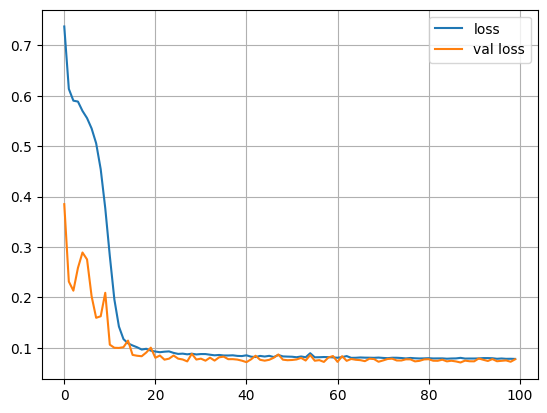

In [9]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()
plt.show()

### Test Model

In [54]:
# scaling factors
k = S_valid
# predictions
preds = m1(X_valid).numpy() * k 
# targets
targets = Y_valid * k

In [62]:
print(preds[0])

[141.99046274 146.73864781  99.20400339 173.54169461  99.89530344
 304.28314969 171.02842922 370.97429806 117.05564608 258.90417312
  17.99575669  45.29780506 135.96722058 189.26652464 557.18789935
 220.89491361  49.64857404 107.39698737]


In [60]:
print(targets[0])

[146.09870911 142.71820068  94.23000336 149.61399841  89.73470306
 281.6138916  145.21862793 351.15667725 174.27427673 246.00746155
  23.19912529  36.9092598  131.71699524 205.71000671 461.65292358
 216.97608948  46.11219025 103.56636047]


In [65]:
shifted_preds = preds[n_timesteps:]

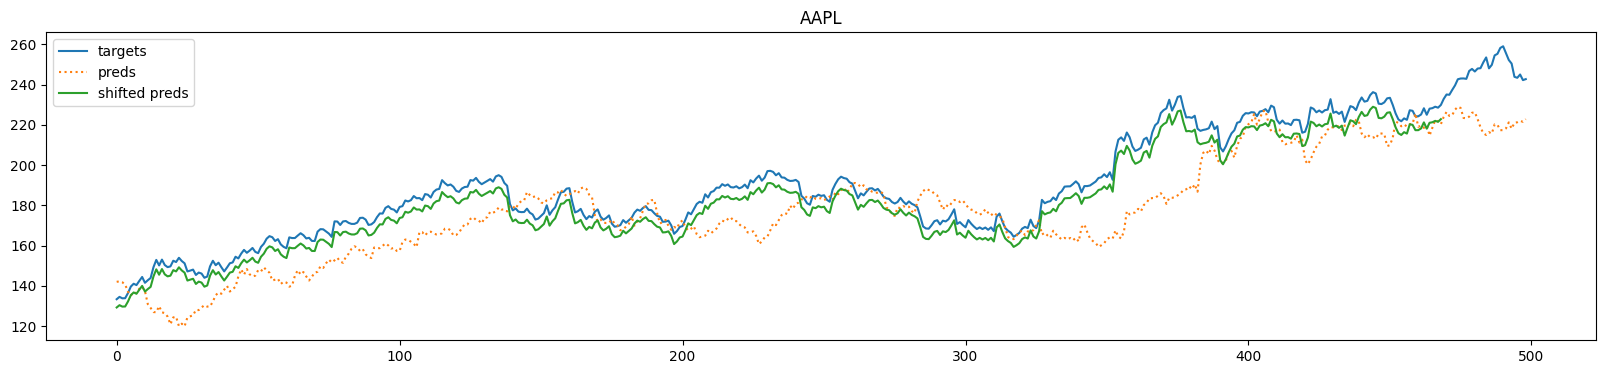

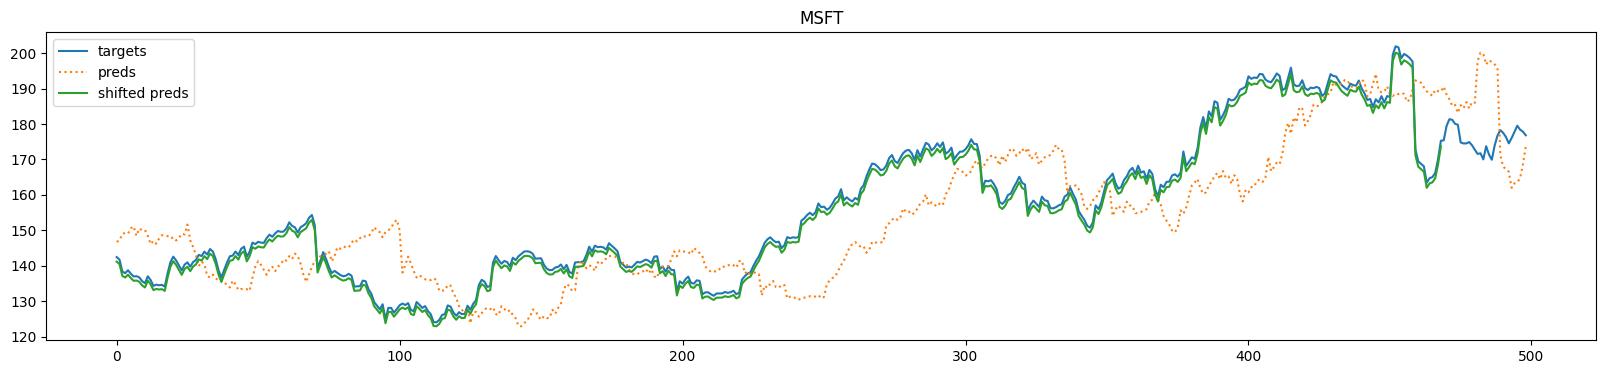

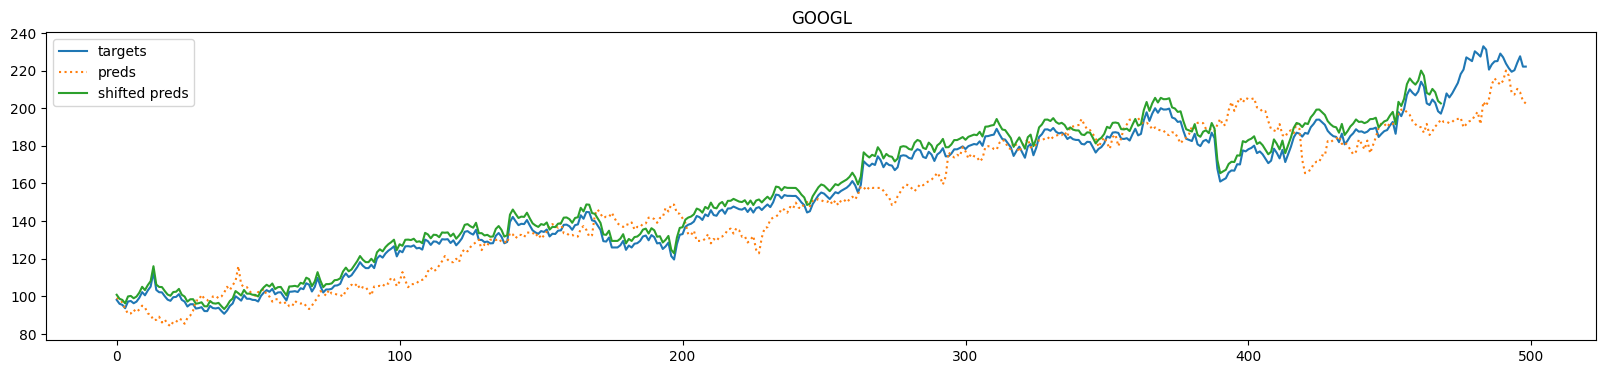

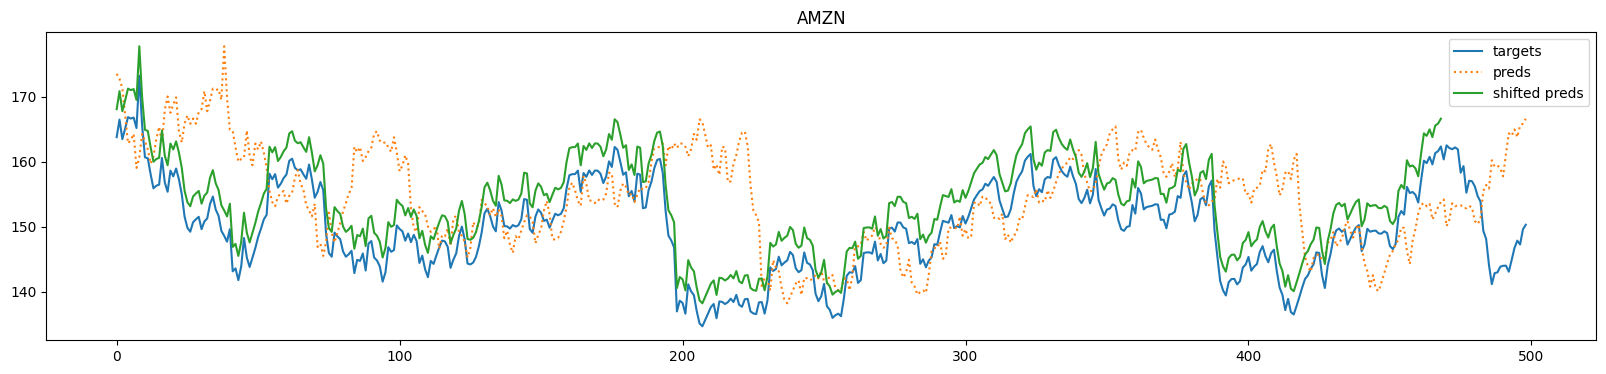

In [70]:
for idx, ticker in enumerate(tickers[:4]):
    plt.figure(figsize=(20,4))
    plt.plot(targets[:,idx],label='targets')
    plt.plot(preds[:,idx],':',label='preds')
    plt.plot(shifted_preds[:,idx],label='shifted preds')
    plt.title(ticker)
    plt.legend()
    plt.show()